## data loading  

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
import seaborn as sns

# extracted feature
trainDS = np.load("/home/jireh/MT/video_sync_v1/trash/featureData.npy",allow_pickle=True)
print(trainDS[0][0].shape)

# Convert to a pandas DataFrame 
df = pd.DataFrame(trainDS)
# Display the first few rows: (left_feature, right_feature, left_id, right_id, delay)
df.head()

2024-09-15 05:15:05.439225: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-15 05:15:06.220388: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-15 05:15:07.726762: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.3/lib64:/usr/include/opencv4
2024-09-15 05:15:07.726869: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvi

(20, 48)


,0,1,2,3,4
0,"[[0.0, 0.0, 0.0, 0.69037163, 0.0, 0.0, 0.0, 0....","[[0.0, 0.0, 0.0, 1.0563793, 0.0, 0.0, 0.0, 0.8...",1963,1983,20
1,"[[0.0, 0.0, 0.0, 0.8872391, 0.0, 0.0, 0.0, 1.2...","[[0.0, 0.0, 0.0, 0.37041047, 0.0, 0.0, 0.0, 0....",8545,8554,9
2,"[[0.0, 0.0, 0.0, 1.340517, 0.0, 0.0, 0.0, 0.64...","[[0.0, 0.0, 0.0, 1.8816519, 0.0, 0.0, 0.0, 0.4...",2322,2326,4
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3974726...","[[0.0, 0.0, 0.0, 0.16040325, 0.0, 0.0, 0.0, 0....",7385,7398,13
4,"[[0.0, 0.0, 0.0, 1.4631886, 0.0, 0.0, 0.0, 0.4...","[[0.0, 0.0, 0.0, 1.233583, 0.0, 0.0, 0.0, 0.16...",7953,7941,-12


## data pre-processing: label: int32 --> matrix(20,20)

In [2]:
def create_diag_matrix(y, sequence_length):
    matrix = np.zeros((sequence_length, sequence_length), dtype=np.float32)
    diag_offset = int(y)
    if -sequence_length < diag_offset < sequence_length:
        effective_length = max(0, sequence_length - abs(diag_offset))  
        if effective_length > 0:
            np.fill_diagonal(matrix[max(0, -diag_offset):, max(0, diag_offset):], 1)
    return matrix

def map_fn(features, y_label):
    sequence_length = 20
    diag_matrix = tf.py_function(func=create_diag_matrix, inp=[y_label, sequence_length], Tout=tf.float32)
    diag_matrix.set_shape((sequence_length, sequence_length)) 
    return features, diag_matrix

# Extracting the features and labels from the training dataset
left_features = trainDS[:, 0].tolist()
right_features = trainDS[:, 1].tolist()
y = trainDS[:, 4].tolist()

# Convert lists to numpy arrays and then to tensors
left_features = np.array(left_features)
right_features = np.array(right_features)
y = np.array(y).astype(np.float32)

left_features = tf.convert_to_tensor(left_features, dtype=tf.float32)
right_features = tf.convert_to_tensor(right_features, dtype=tf.float32)

# Split the dataset into training and validation sets
size = int(len(y) * 0.8)  # Use 80% of the data for training
left_features_train, left_features_val = left_features[:size], left_features[size:]
right_features_train, right_features_val = right_features[:size], right_features[size:]
y_train, y_val = y[:size], y[size:]

# Creating TensorFlow datasets without preprocessing labels in advance
train_dataset = tf.data.Dataset.from_tensor_slices(({'query': left_features_train, 'context': right_features_train}, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024)

# Use a map function to convert y to diagonal matrices
train_dataset = train_dataset.map(map_fn).batch(256,drop_remainder=True).repeat()

# Construct the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices(({'query': left_features_val, 'context': right_features_val}, y_val))
val_dataset = val_dataset.map(map_fn).batch(32,drop_remainder=True)

#print changed label
for batch in train_dataset.take(1):
    inputs, y_true = batch
    print("True:\n", y_true[7])

# Calculate the number of training and validation steps per epoch
train_steps_per_epoch = len(left_features_train) // 256
val_steps_per_epoch = len(left_features_val) // 32

2024-09-15 05:15:10.607460: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-15 05:15:10.714010: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-15 05:15:10.714861: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-15 05:15:10.722961: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

True:
 tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.

## model

In [3]:
class MultiHeadAttentionModel(tf.keras.Model):
    def __init__(self, num_heads, key_dim, sequence_length):
        super(MultiHeadAttentionModel, self).__init__()
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.sequence_length = sequence_length

        # Define MultiHeadAttention layer
        self.attention_layer = MultiHeadAttention(num_heads=self.num_heads, key_dim=self.key_dim)

    def call(self, inputs):
        query = inputs['query']
        context = inputs['context']

        # Forward pass of MultiHeadAttention
        _, attention_scores = self.attention_layer(query=query, key=context, value=context, return_attention_scores=True)

        # Process attention_scores with diagonal operations
        similarity_matrix = tf.reduce_mean(attention_scores, axis=1)

        # Output the processed result with diagonal operations
        return similarity_matrix


## Callback and Visualization

In [4]:
class PredictionCallback(Callback):
    def __init__(self, val_data):
        super(PredictionCallback, self).__init__()
        self.val_data = val_data
    
    def on_train_end(self, logs=None):
        # Take the first batch of validation samples at the end of training
        for batch in self.val_data.take(1):
            inputs, y_true = batch
            y_pred = self.model.predict(inputs)

            # Print final predictions and corresponding true values after training
            print("\nFinal predictions after training:")
            print("Predicted:\n", y_pred[0])
            print("True:\n", y_true[0])
            
            distance, heatmap = self.find_largest_diag(y_pred[0])
            # Plot the heatmap
            plt.figure(figsize=(20, 20))
            sns.heatmap(y_pred[0], annot=True, cmap="coolwarm")
            plt.title(f'predition: {distance}')
            plt.show()

            plt.figure(figsize=(20, 20))
            sns.heatmap(heatmap, annot=True, cmap="coolwarm")
            plt.title('predition heatmap (row and column maxima)')
            plt.show()
            
            plt.figure(figsize=(20, 20))
            sns.heatmap(y_true[0], annot=True, cmap="coolwarm")
            plt.title('True Labels Heatmap')
            plt.show()
            
    def find_largest_diag(self, similarity_matrix):
        # Get matrix dimensions
        n = similarity_matrix.shape[0]

        # Convert to TensorFlow tensor
        sim_matrix = tf.constant(similarity_matrix, dtype=tf.float32)

        # Find the position of the maximum value in each row
        row_max_indices = []
        for i in range(n):
            row_idx = tf.argmax(sim_matrix[i, :])
            row_max_indices.append(tf.round(row_idx))  # Round the softargmax result to integer index
        row_max_indices = tf.stack(row_max_indices)
        print("Row max indices (rounded):", row_max_indices)

        # Find the position of the maximum value in each column
        col_max_indices = []
        for i in range(n):
            col_idx = tf.argmax(sim_matrix[:, i])
            col_max_indices.append(tf.round(col_idx))  # Similarly, round each column result
        col_max_indices = tf.stack(col_max_indices)
        print("Column max indices (rounded):", col_max_indices)

        # Create a heatmap to mark the maximum values
        heatmap = np.zeros_like(similarity_matrix)
        for i in range(n):
            row_idx = int(row_max_indices[i].numpy())
            col_idx = int(col_max_indices[i].numpy())

            # Ensure indices are within matrix dimensions
            if 0 <= row_idx < n:
                heatmap[i, row_idx] += 1  # Mark the maximum value in each row
            if 0 <= col_idx < n:
                heatmap[col_idx, i] += 1  # Mark the maximum value in each column

        # Find the diagonal with the most marks
        max_diag_marks = -1
        max_diag_idx = 0
        for diag_idx in range(-n+1, n):
            diag_marks = np.sum(np.diag(heatmap, k=diag_idx))
            if diag_marks > max_diag_marks:
                max_diag_marks = diag_marks
                max_diag_idx = diag_idx

        # Calculate the distance of the optimal diagonal from the center diagonal
        distance = max_diag_idx

        # Return the distance and the heatmap
        return distance, heatmap

## loss defined (3 choice at the moment but not working)
### - Logarithmic Squared Error with Weighted Loss.     #problem: the model learned some weird results.
### - Mean Squared Error with Weighted Loss.       #problem: the model learned nothing, quite weird.
### - Binary Cross-Entropy Loss.      #problem: the model learned nothing.

In [5]:
# def custom_loss(y_true, y_pred):
#     epsilon = 1e-7  # in case log(0)
#     weights = tf.where(y_true > 0, 30.0, 1.0)
#     return tf.reduce_mean( weights * tf.square(tf.math.log(y_true + epsilon) - tf.math.log(y_pred + epsilon)))

# # def custom_loss(y_true, y_pred):
# #     weights = tf.where(y_true > 0, 10.0, 1.0)  
# #     return tf.reduce_mean(weights * tf.square(y_true - y_pred))

# # def custom_loss(y_true, y_pred):
# #     bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
# #     return bce(y_true,y_pred)


# Define custom loss function for batched input
def custom_loss(y_true, y_pred):
    # Row-wise softmax
    y_pred_row_softmax = tf.nn.softmax(y_pred, axis=-1)  # Softmax along rows (axis=-1)
    # Column-wise softmax
    y_pred_col_softmax = tf.nn.softmax(y_pred, axis=-2)  # Softmax along columns (axis=-2)
    
    # Row-wise cross-entropy loss (batch-wise operation)
    row_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred_row_softmax)

    # Transpose y_true and y_pred for column-wise loss (only last two dimensions)
    y_true_transposed = tf.transpose(y_true, perm=[0, 2, 1])  # Swap last two dimensions for batched input
    y_pred_col_softmax_transposed = tf.transpose(y_pred_col_softmax, perm=[0, 2, 1])
    
    # Column-wise cross-entropy loss
    col_loss = tf.keras.losses.categorical_crossentropy(y_true_transposed, y_pred_col_softmax_transposed)
    
    # Final loss is the average of row and column losses
    total_loss = (tf.reduce_sum(row_loss) + tf.reduce_sum(col_loss)) / 2
    
    return total_loss

In [6]:
# Test data
y_true_test = np.eye(20)  # Ground truth (identity matrix, one-hot for each row)
y_true_test = np.expand_dims(y_true_test, axis=0)
y_pred_test = np.random.rand(1, 20, 20)  # Random predictions

# Convert test data to tensors
y_true_tensor = tf.convert_to_tensor(y_true_test, dtype=tf.float32)
y_pred_tensor = tf.convert_to_tensor(y_pred_test, dtype=tf.float32)

# Compute loss using the custom function
loss_value = custom_loss(y_true_tensor, y_pred_tensor)

# Output loss value
print(loss_value)

tf.Tensor(59.94808, shape=(), dtype=float32)


Epoch 1/200
62/62 [==============================] - 12s 186ms/step - loss: 174.6132 - val_loss: 174.5786
Epoch 2/200
62/62 [==============================] - 12s 195ms/step - loss: 174.5843 - val_loss: 174.4587
Epoch 3/200
62/62 [==============================] - 11s 182ms/step - loss: 173.8506 - val_loss: 172.5001
Epoch 4/200
62/62 [==============================] - 12s 190ms/step - loss: 169.4803 - val_loss: 165.2697
Epoch 5/200
62/62 [==============================] - 12s 192ms/step - loss: 160.5660 - val_loss: 155.4671
Epoch 6/200
62/62 [==============================] - 12s 188ms/step - loss: 152.2737 - val_loss: 149.1566
Epoch 7/200
62/62 [==============================] - 11s 183ms/step - loss: 147.9814 - val_loss: 146.5955
Epoch 8/200
62/62 [==============================] - 12s 192ms/step - loss: 146.1050 - val_loss: 145.2443
Epoch 9/200
62/62 [==============================] - 12s 186ms/step - loss: 144.3241 - val_loss: 142.8689
Epoch 10/200
62/62 [==========================

62/62 [==============================] - 12s 189ms/step - loss: 132.6433 - val_loss: 132.3071
Epoch 70/200
62/62 [==============================] - 12s 192ms/step - loss: 132.6487 - val_loss: 132.2788
Epoch 71/200
62/62 [==============================] - 12s 194ms/step - loss: 132.6152 - val_loss: 132.1463
Epoch 72/200
62/62 [==============================] - 12s 192ms/step - loss: 132.5661 - val_loss: 132.1080
Epoch 73/200
62/62 [==============================] - 12s 194ms/step - loss: 132.5808 - val_loss: 132.1547
Epoch 74/200
62/62 [==============================] - 12s 194ms/step - loss: 132.5046 - val_loss: 132.2124
Epoch 75/200
62/62 [==============================] - 12s 195ms/step - loss: 132.5424 - val_loss: 132.1062
Epoch 76/200
62/62 [==============================] - 12s 190ms/step - loss: 132.5015 - val_loss: 132.0975
Epoch 77/200
62/62 [==============================] - 12s 190ms/step - loss: 132.4719 - val_loss: 132.1210
Epoch 78/200
62/62 [==============================

Row max indices (rounded): tf.Tensor([5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5], shape=(20,), dtype=int64)
Column max indices (rounded): tf.Tensor([ 4  4 12 13  4  9  5  5  4  4  5  5  4  5  5  5  5  5  5  4], shape=(20,), dtype=int64)


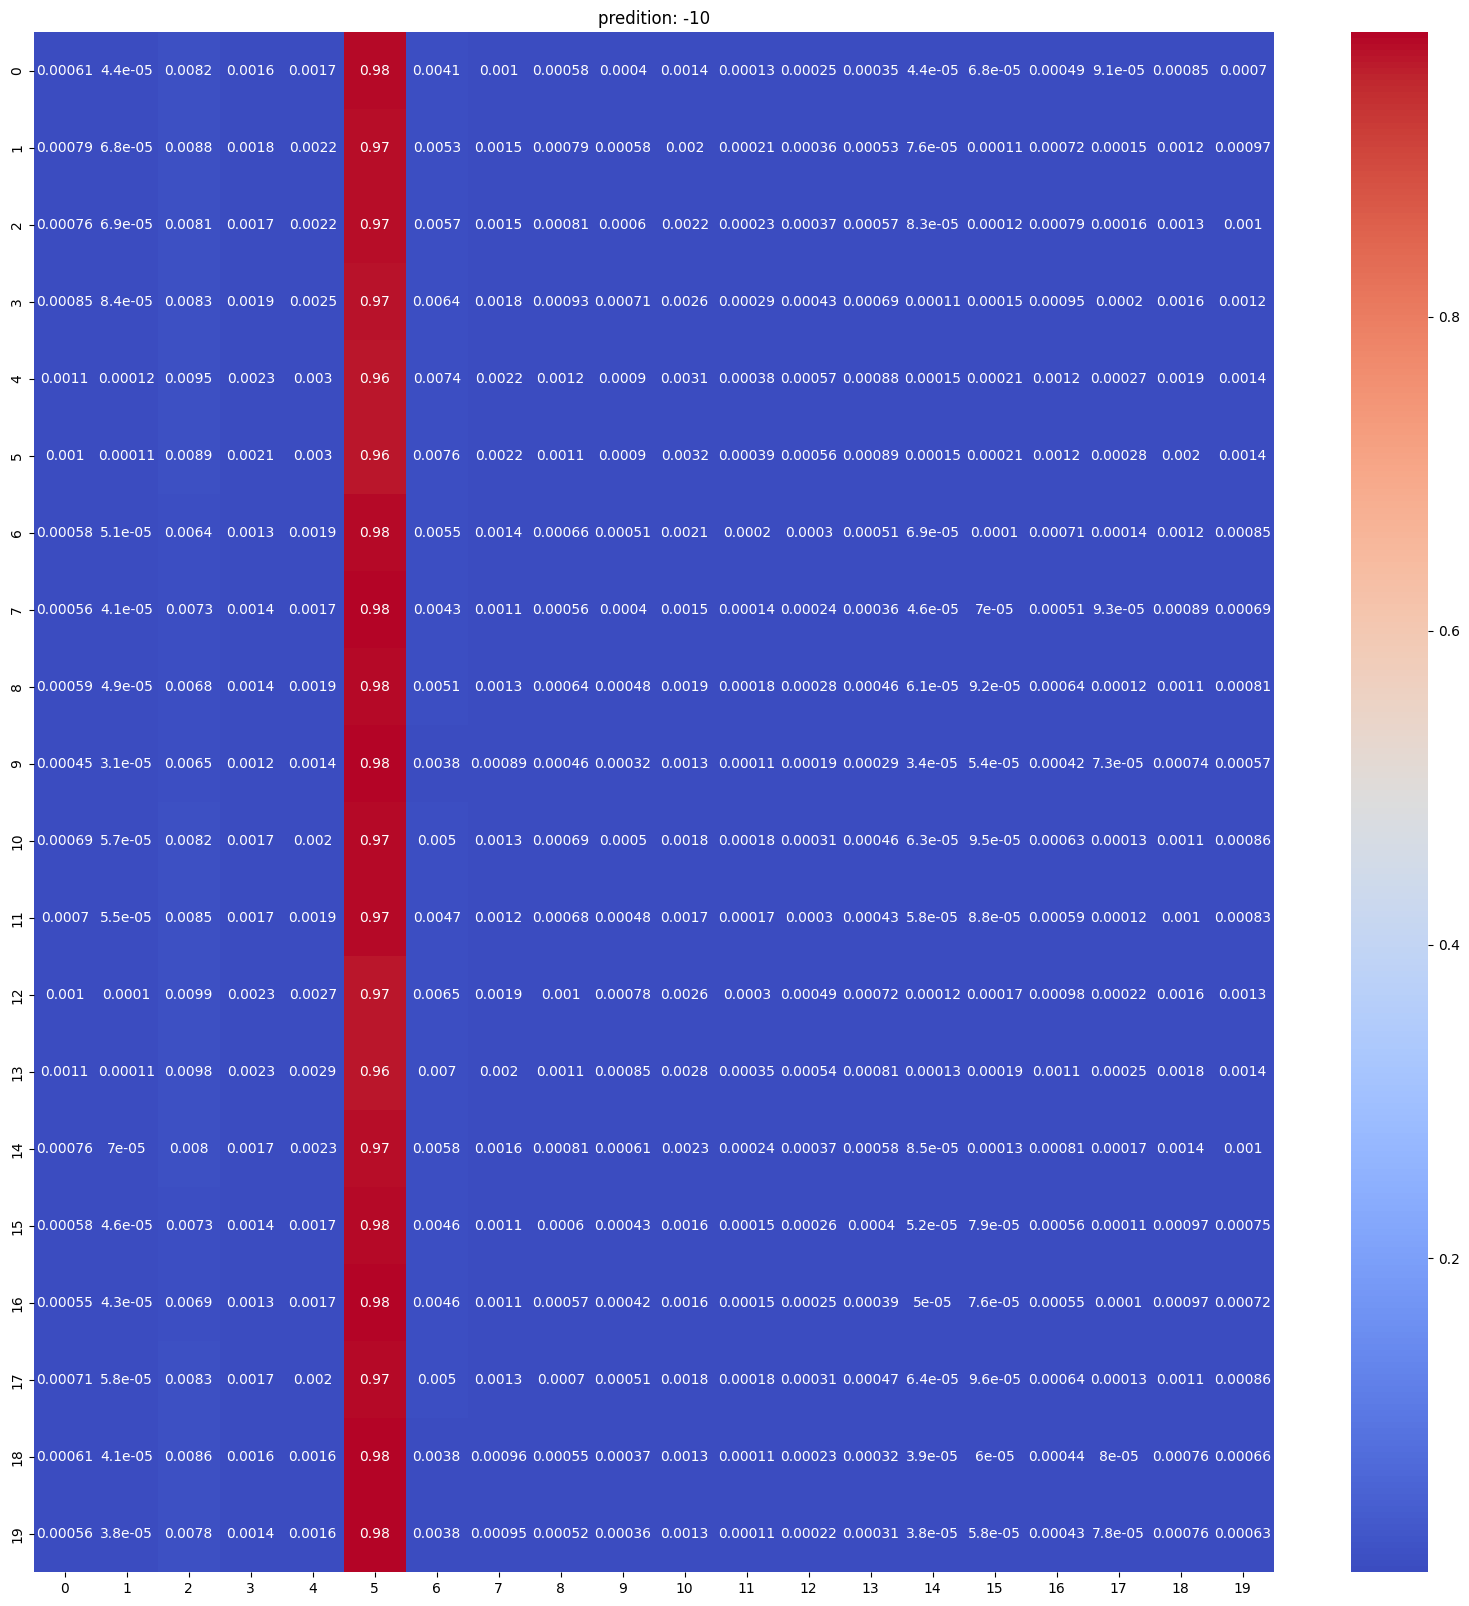

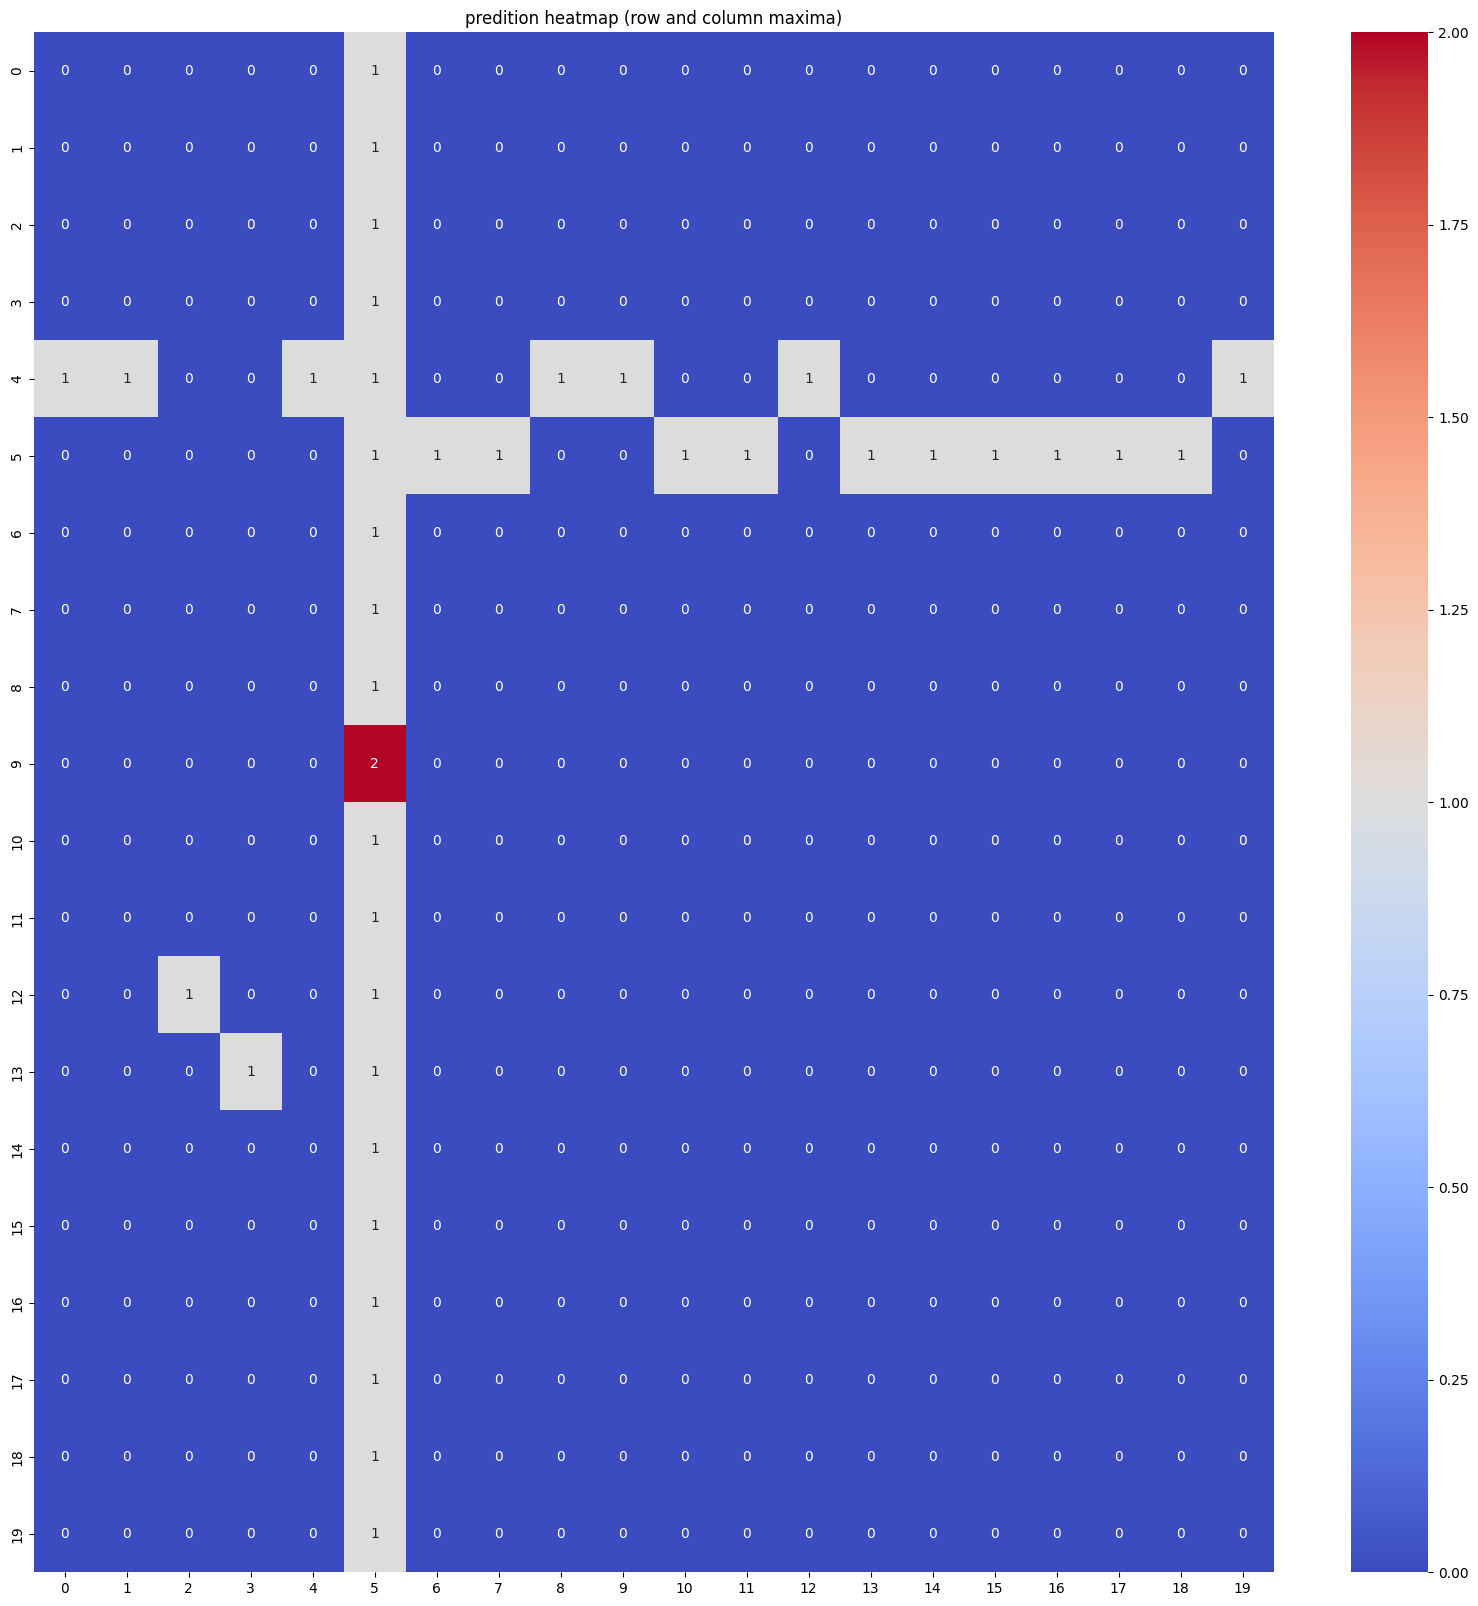

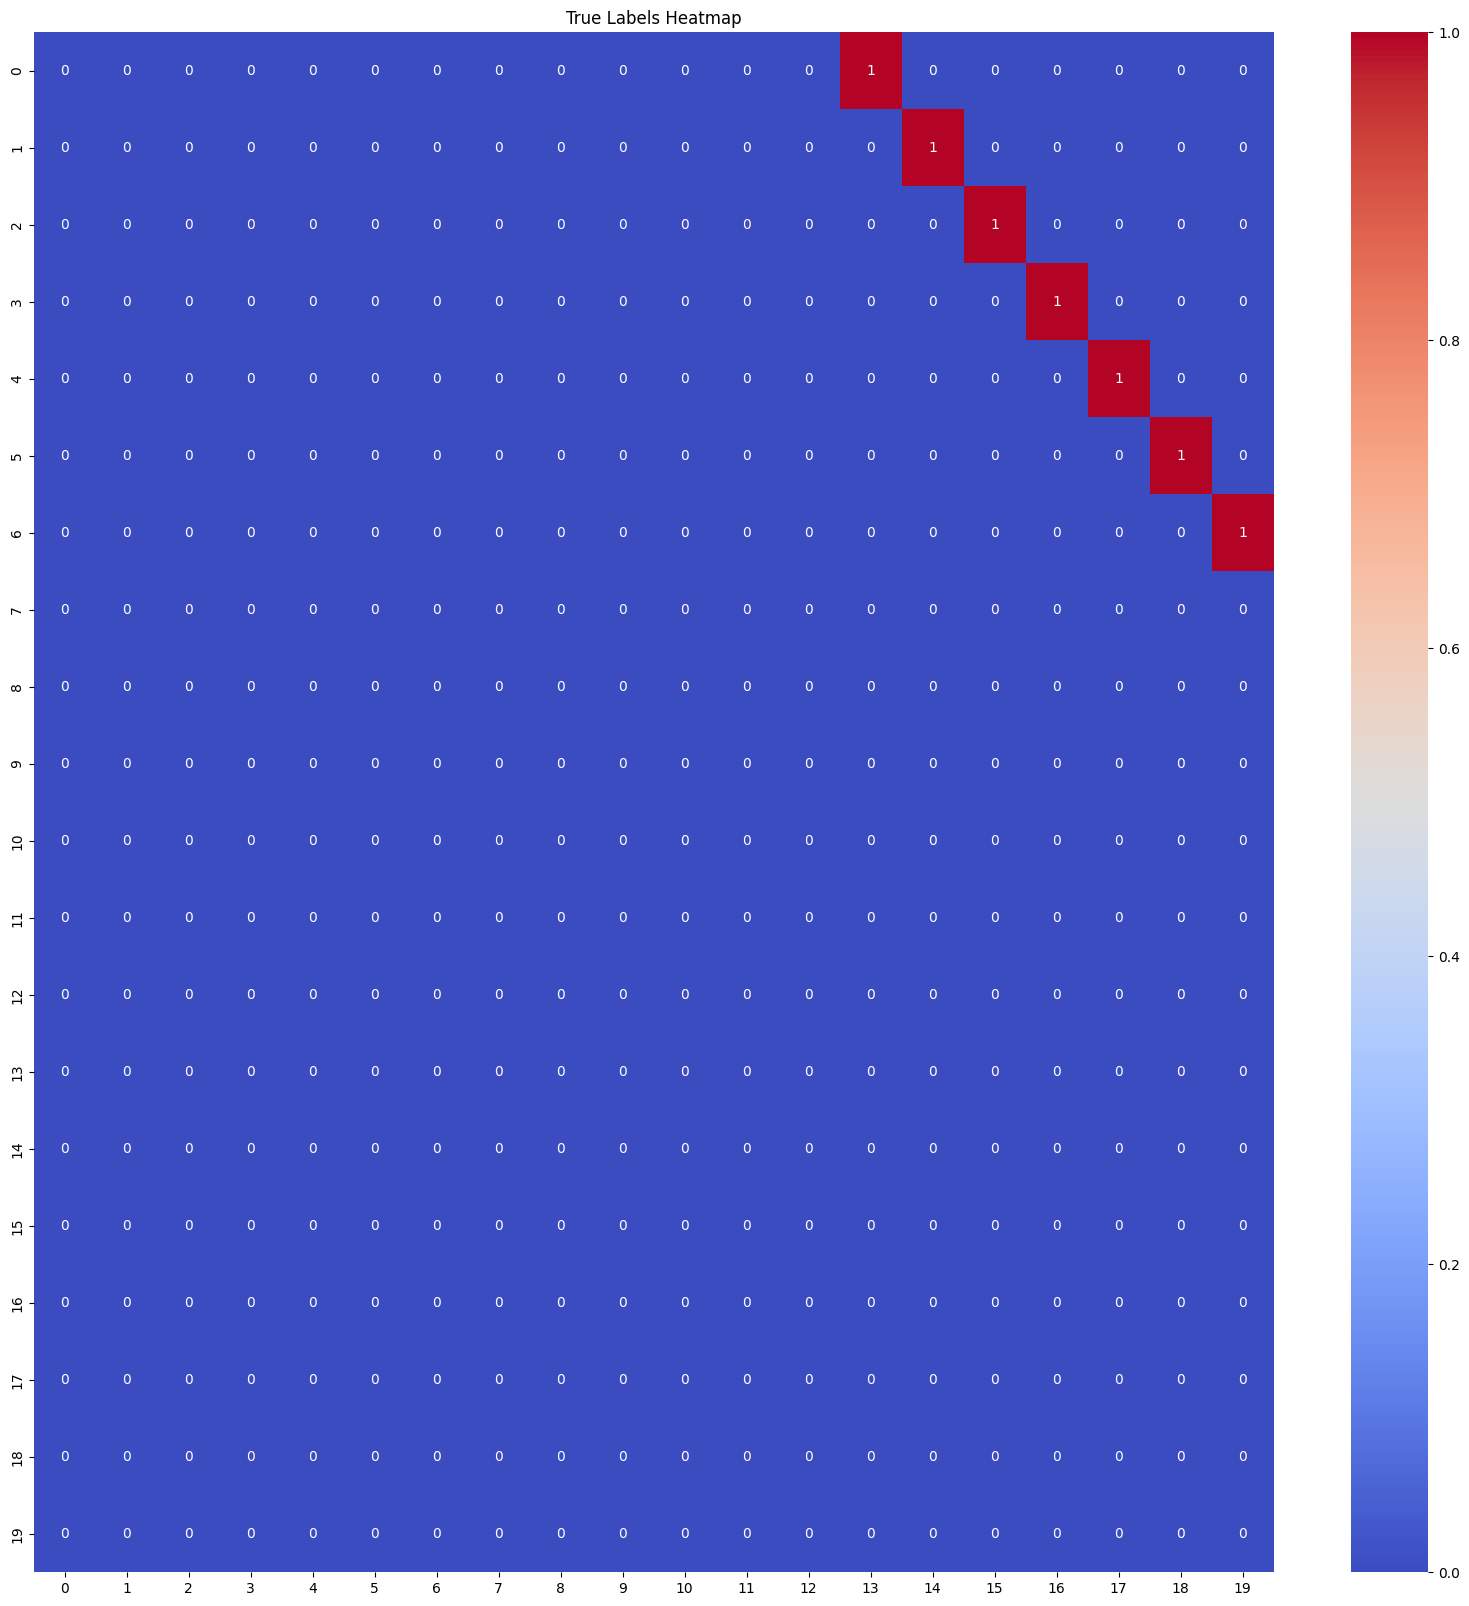

In [7]:
### model training: with loss_1

### problem: the model learned some weird results.

# Instantiate the model
mha_model = MultiHeadAttentionModel(num_heads=4, key_dim=48, sequence_length=20)

# Compile the model using the custom loss function
optimizer = Adam(learning_rate=1e-4)
mha_model.compile(optimizer=optimizer, loss=custom_loss)

# Train the model with the specified datasets, number of epochs, and callbacks
mha_model.fit(
    train_dataset,
    epochs=200,
    steps_per_epoch=train_steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=val_steps_per_epoch,
    callbacks=[PredictionCallback(val_dataset)]
)

Epoch 1/30
31/31 [==============================] - 7s 204ms/step - loss: 0.0248 - val_loss: 0.0247
Epoch 2/30
31/31 [==============================] - 6s 210ms/step - loss: 0.0250 - val_loss: 0.0252
Epoch 3/30
31/31 [==============================] - 6s 208ms/step - loss: 0.0248 - val_loss: 0.0246
Epoch 4/30
31/31 [==============================] - 6s 213ms/step - loss: 0.0249 - val_loss: 0.0250
Epoch 5/30
31/31 [==============================] - 7s 213ms/step - loss: 0.0249 - val_loss: 0.0249
Epoch 6/30
31/31 [==============================] - 7s 219ms/step - loss: 0.0249 - val_loss: 0.0254
Epoch 7/30
31/31 [==============================] - 7s 214ms/step - loss: 0.0248 - val_loss: 0.0252
Epoch 8/30
31/31 [==============================] - 7s 228ms/step - loss: 0.0249 - val_loss: 0.0251
Epoch 9/30
31/31 [==============================] - 7s 224ms/step - loss: 0.0248 - val_loss: 0.0248
Epoch 10/30
31/31 [==============================] - 7s 227ms/step - loss: 0.0250 - val_loss: 0.0254

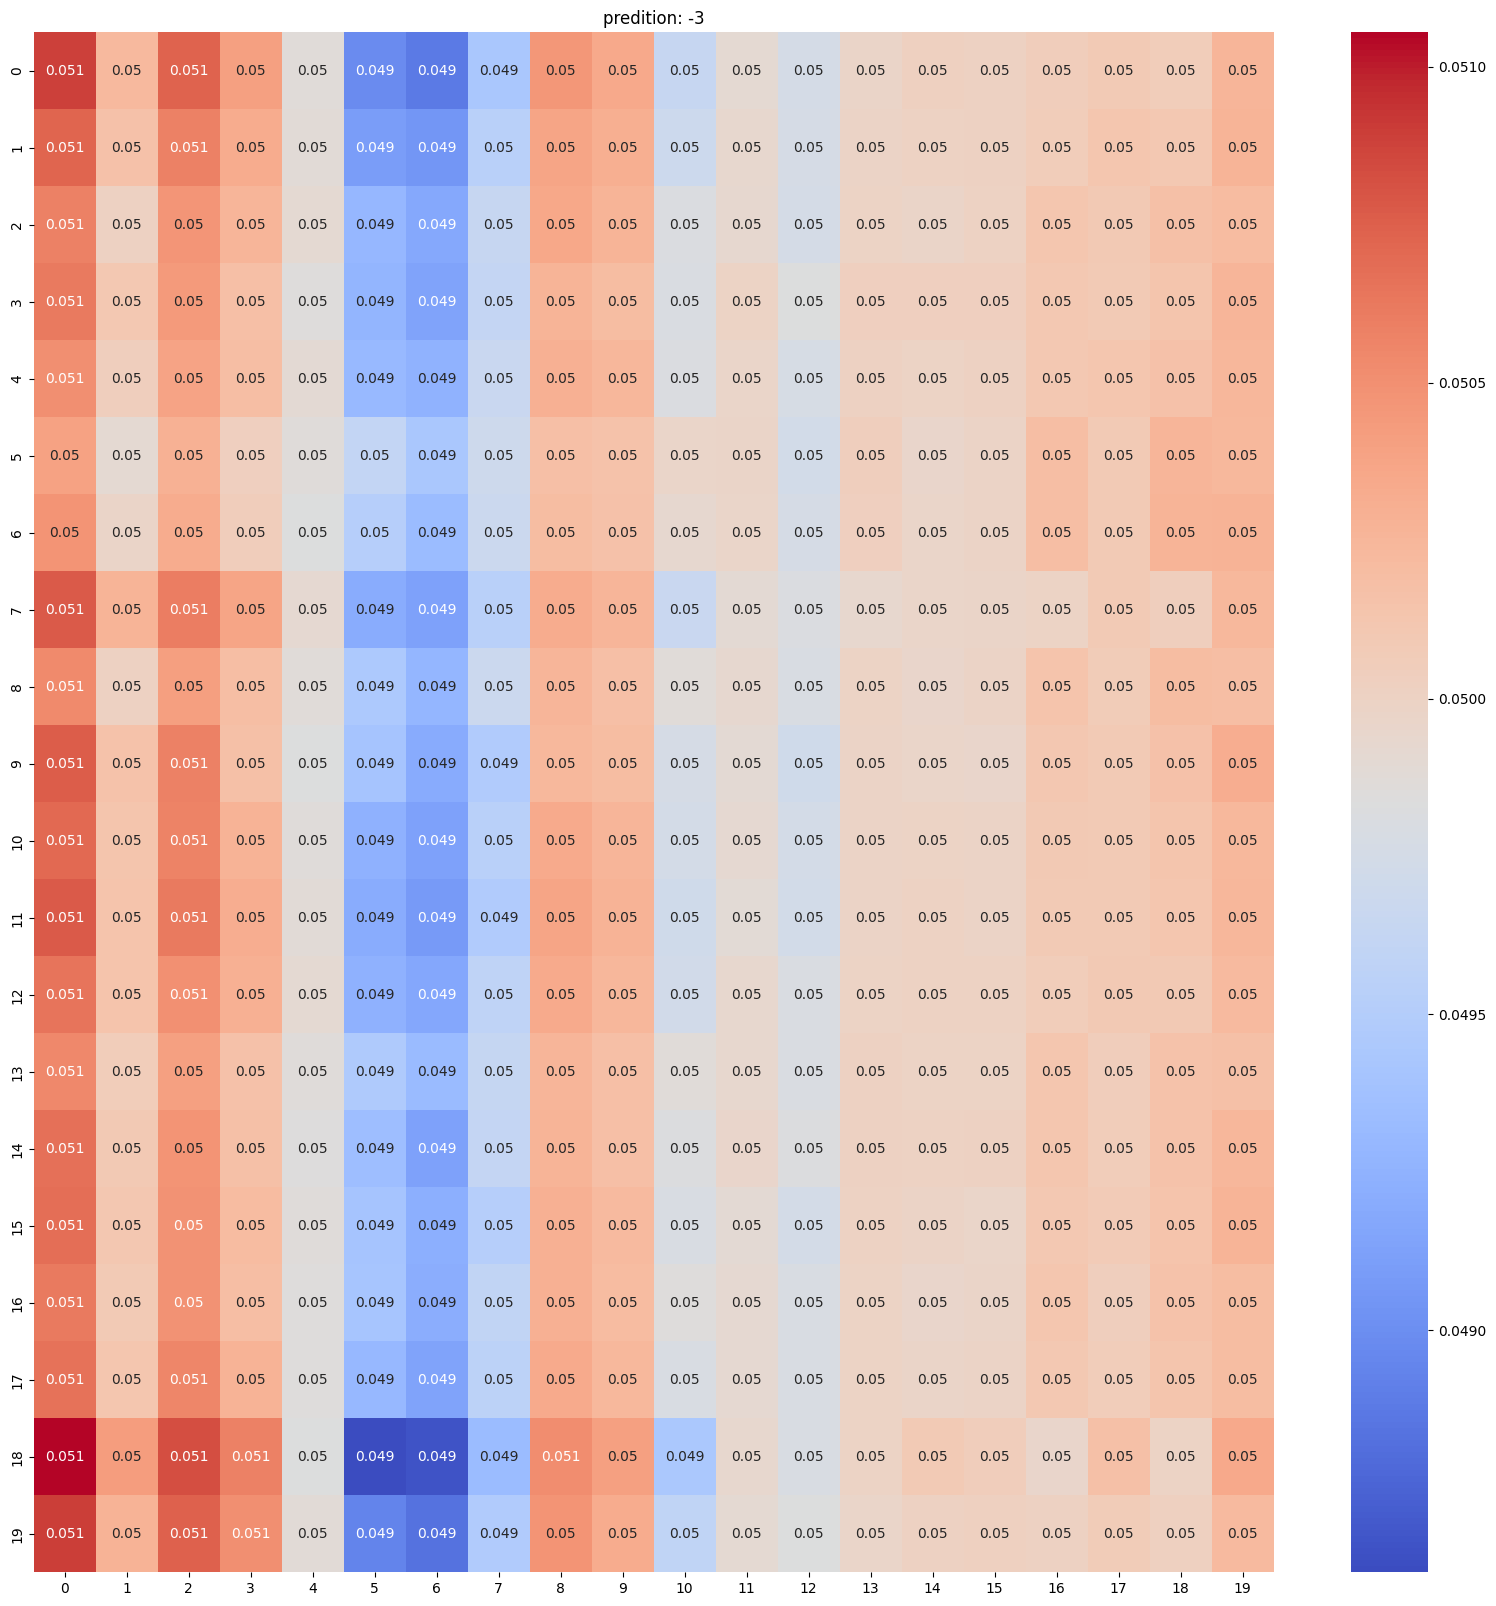

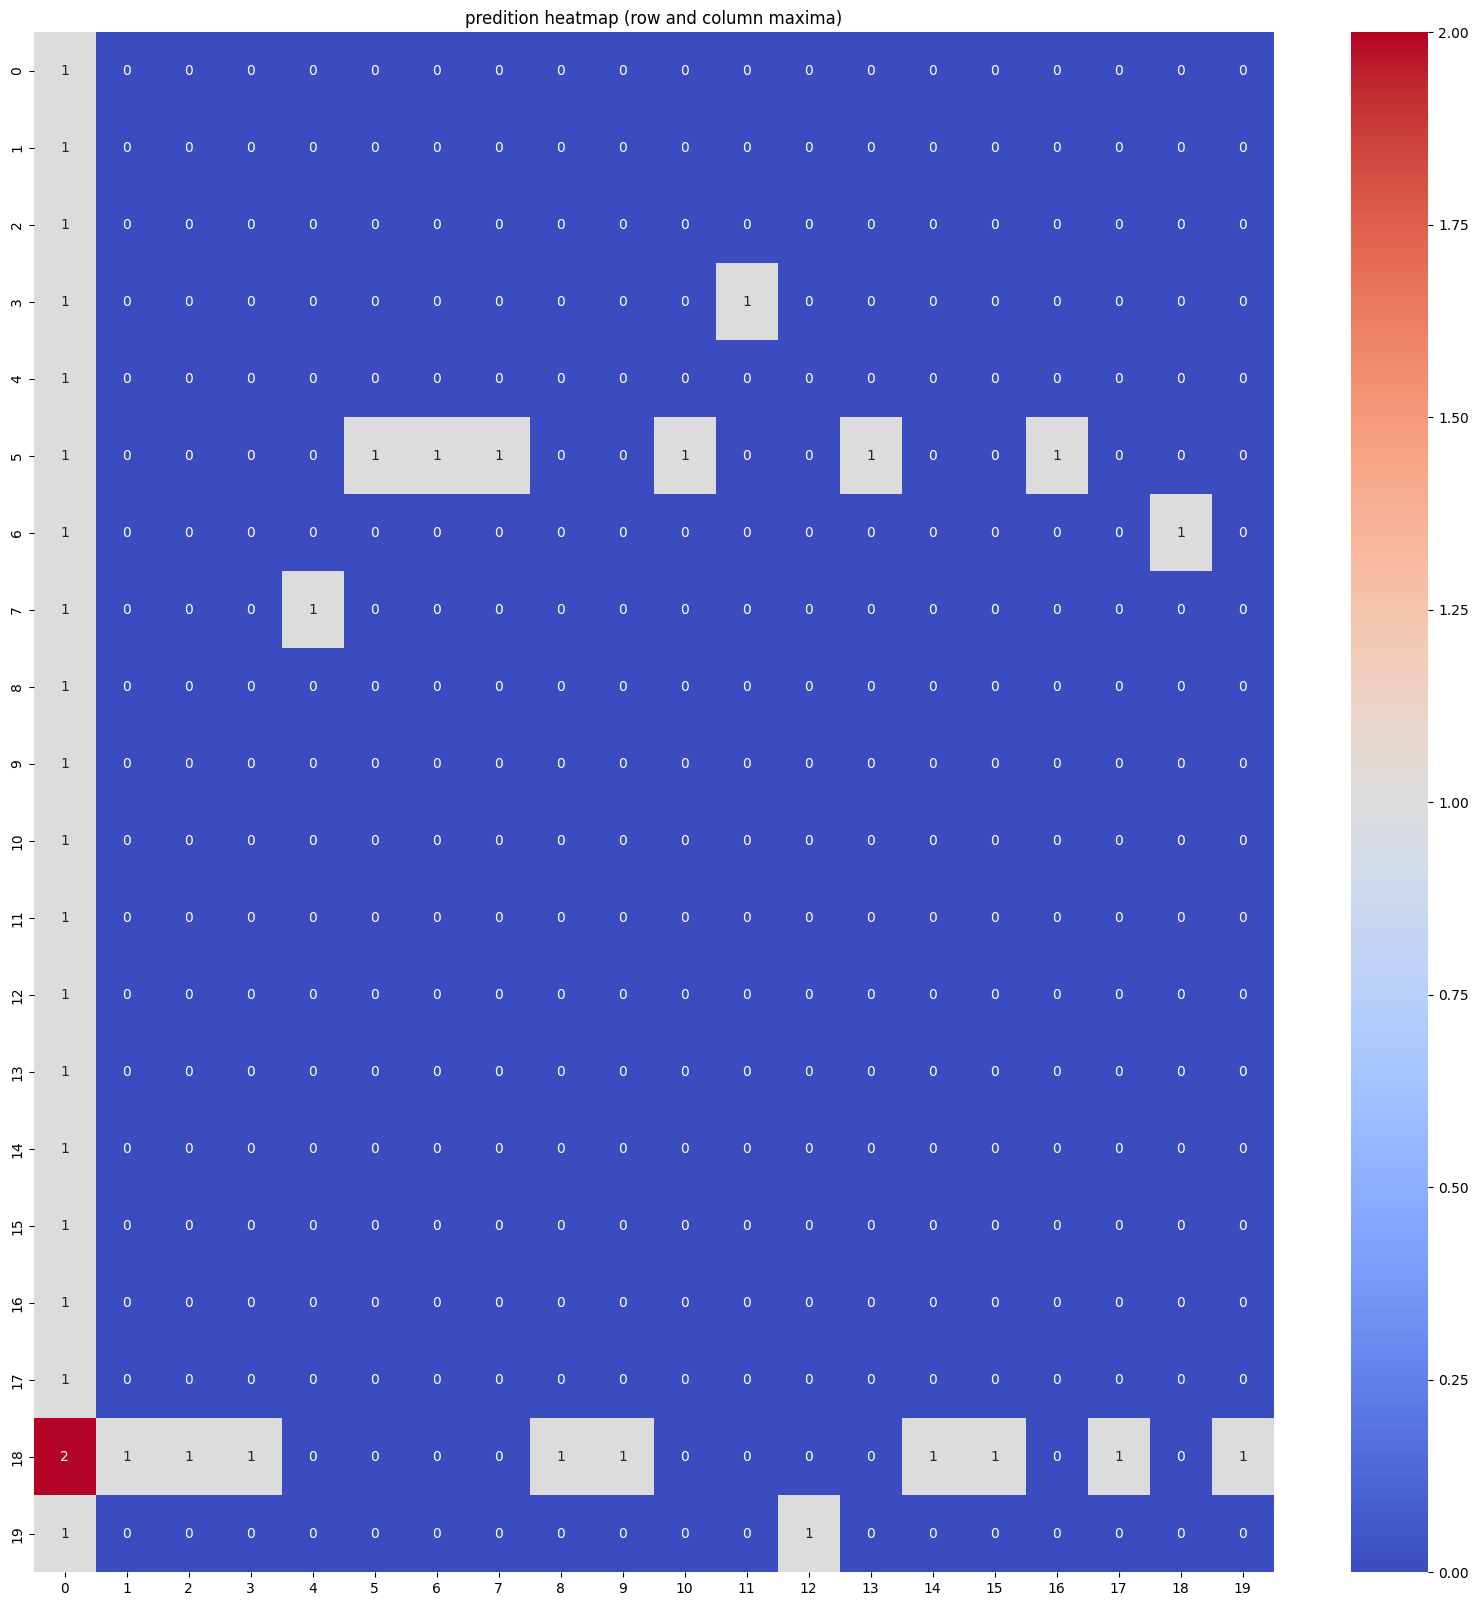

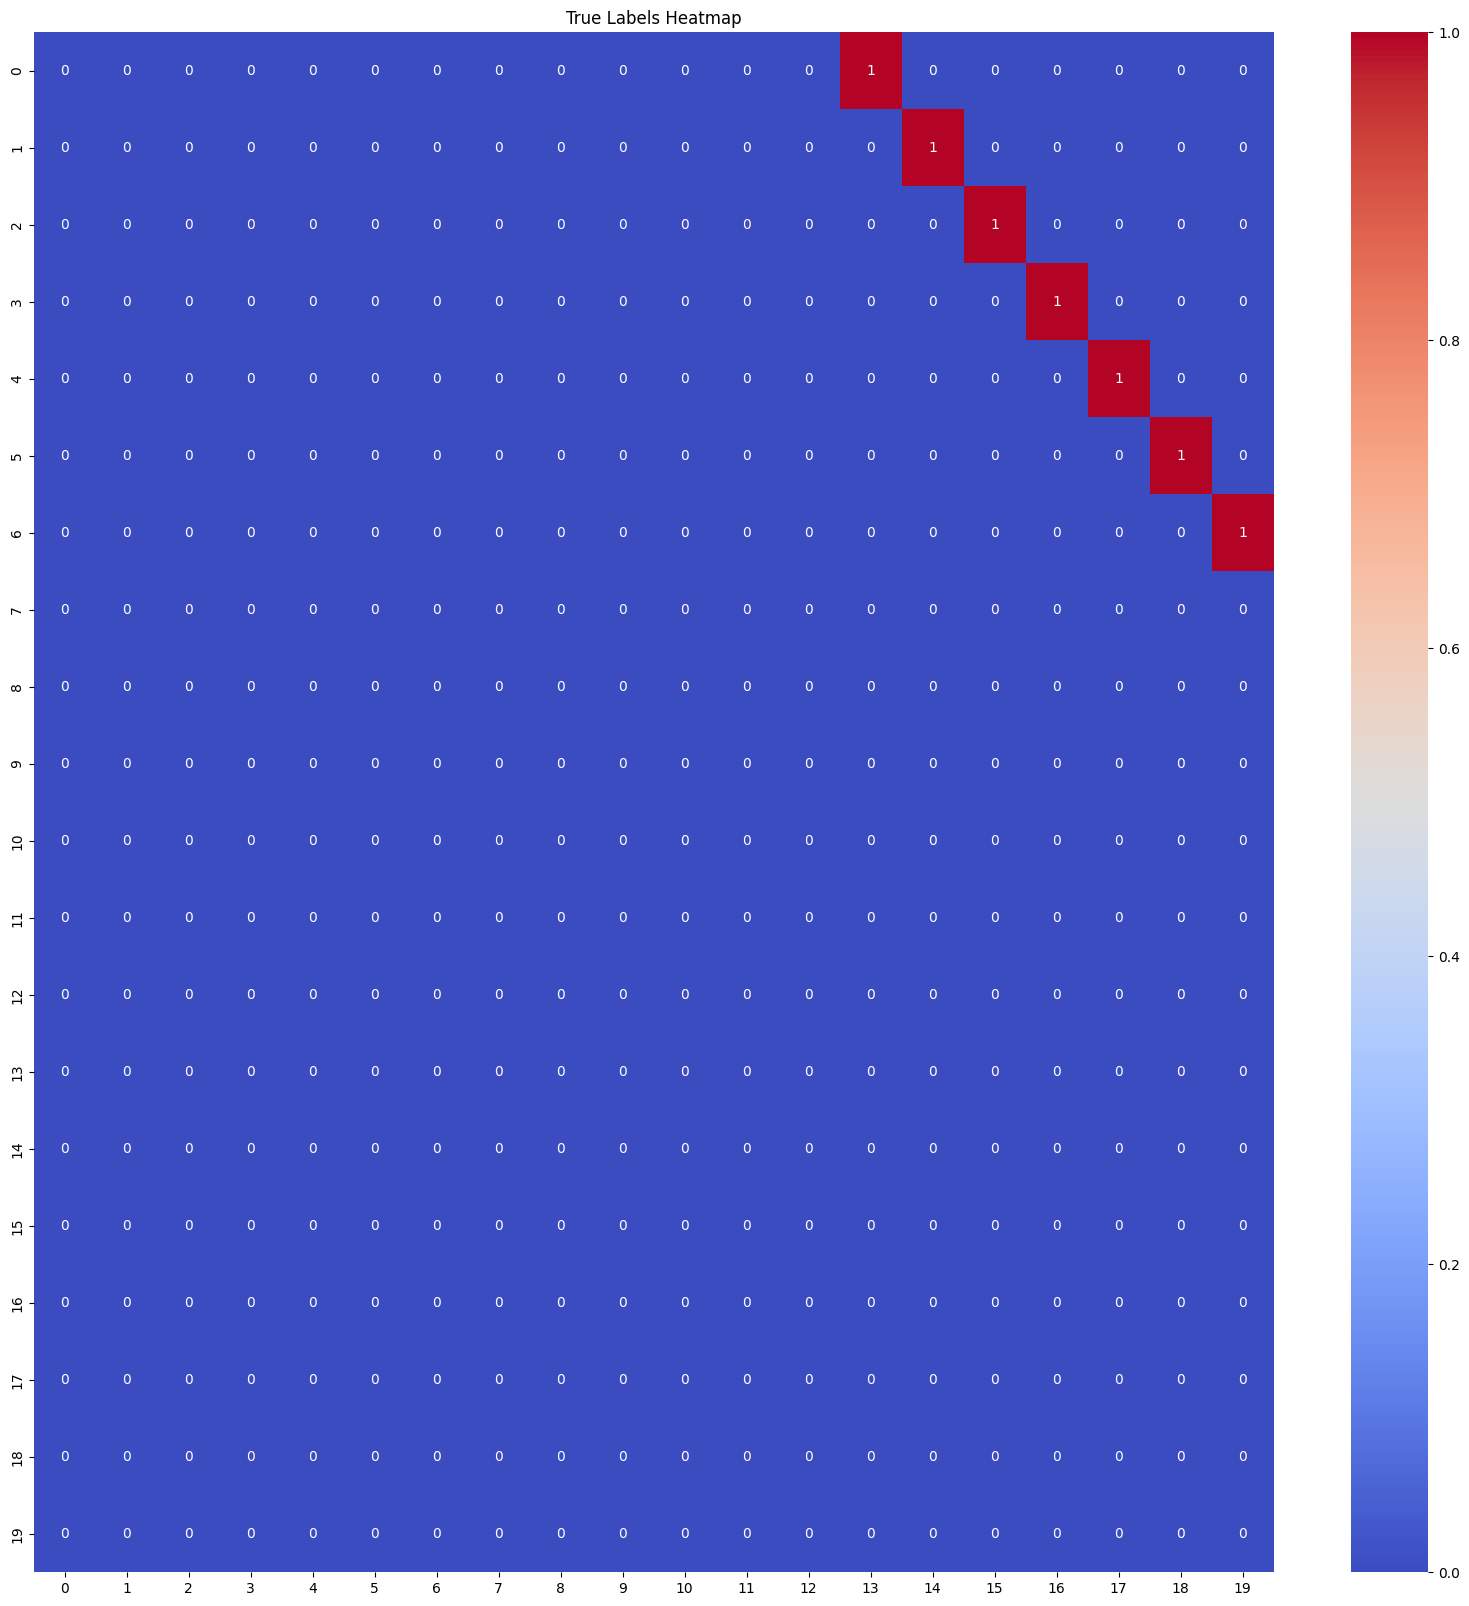

In [7]:
### model training: with loss_2

### problem: the model learned nothing, quite weird.

# Instantiate the model
mha_model = MultiHeadAttentionModel(num_heads=4, key_dim=48, sequence_length=20)

# Compile the model using the custom loss function
optimizer = Adam(learning_rate=1e-4)
mha_model.compile(optimizer=optimizer, loss=custom_loss)

# Train the model with the specified datasets, number of epochs, and callbacks
mha_model.fit(
    train_dataset,
    epochs=30,
    steps_per_epoch=train_steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=val_steps_per_epoch,
    callbacks=[PredictionCallback(val_dataset)]
)

Epoch 1/30
31/31 [==============================] - 7s 205ms/step - loss: 0.1249 - val_loss: 0.1263
Epoch 2/30
31/31 [==============================] - 6s 207ms/step - loss: 0.1243 - val_loss: 0.1250
Epoch 3/30
31/31 [==============================] - 6s 207ms/step - loss: 0.1250 - val_loss: 0.1229
Epoch 4/30
31/31 [==============================] - 6s 205ms/step - loss: 0.1237 - val_loss: 0.1261
Epoch 5/30
31/31 [==============================] - 6s 207ms/step - loss: 0.1250 - val_loss: 0.1252
Epoch 6/30
31/31 [==============================] - 6s 212ms/step - loss: 0.1241 - val_loss: 0.1263
Epoch 7/30
31/31 [==============================] - 6s 198ms/step - loss: 0.1244 - val_loss: 0.1248
Epoch 8/30
31/31 [==============================] - 6s 198ms/step - loss: 0.1246 - val_loss: 0.1259
Epoch 9/30
31/31 [==============================] - 6s 197ms/step - loss: 0.1244 - val_loss: 0.1244
Epoch 10/30
31/31 [==============================] - 6s 199ms/step - loss: 0.1246 - val_loss: 0.1260

Row max indices (rounded): tf.Tensor([ 2  2  2  2  2  2  2  2 13 19  2  2  2  2  8  2  2  2  2  8], shape=(20,), dtype=int64)
Column max indices (rounded): tf.Tensor([18 18 18 18  4 13 13  8 18 18 14 19 19 14 19 19  8 18  5  9], shape=(20,), dtype=int64)


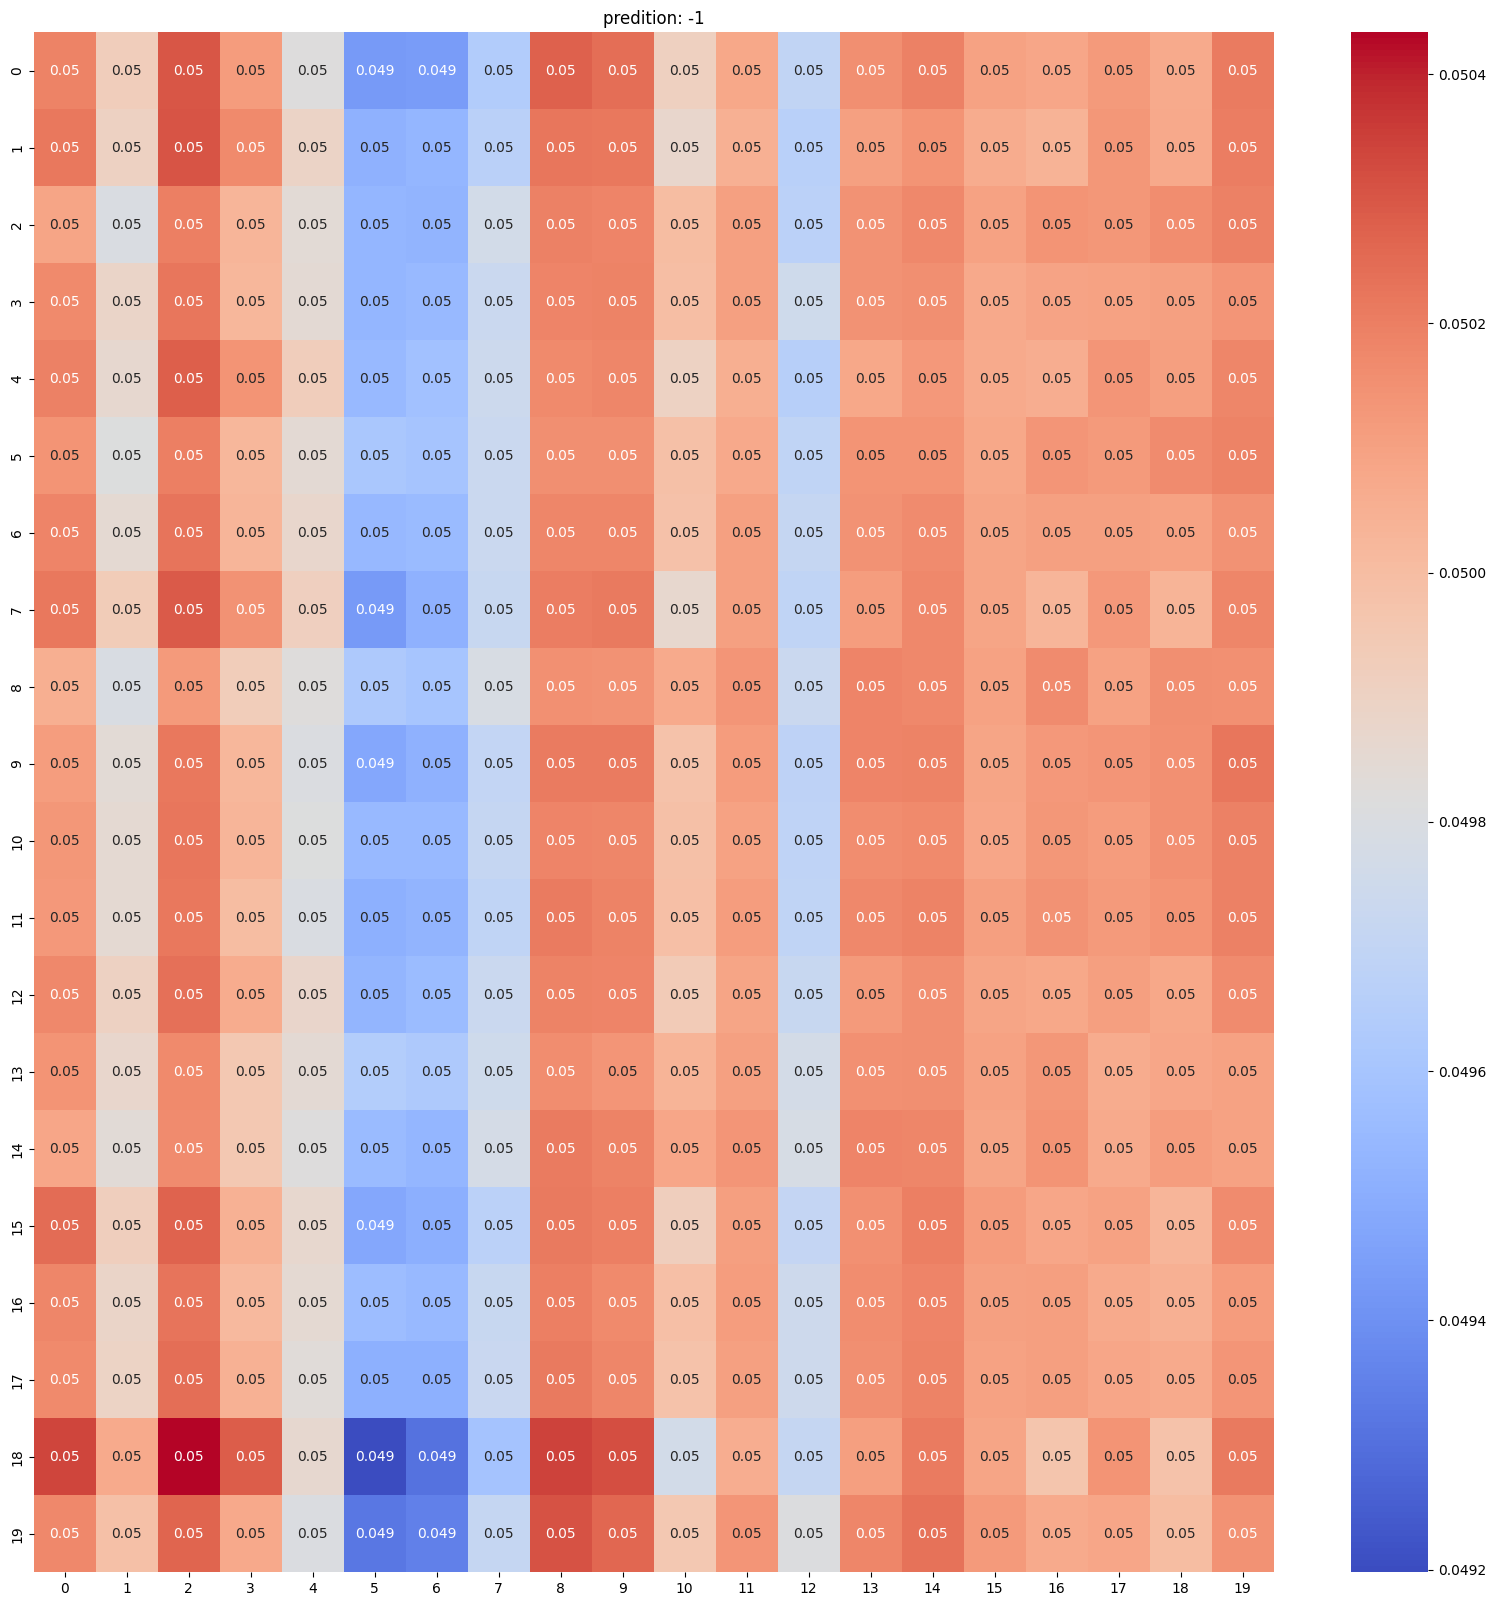

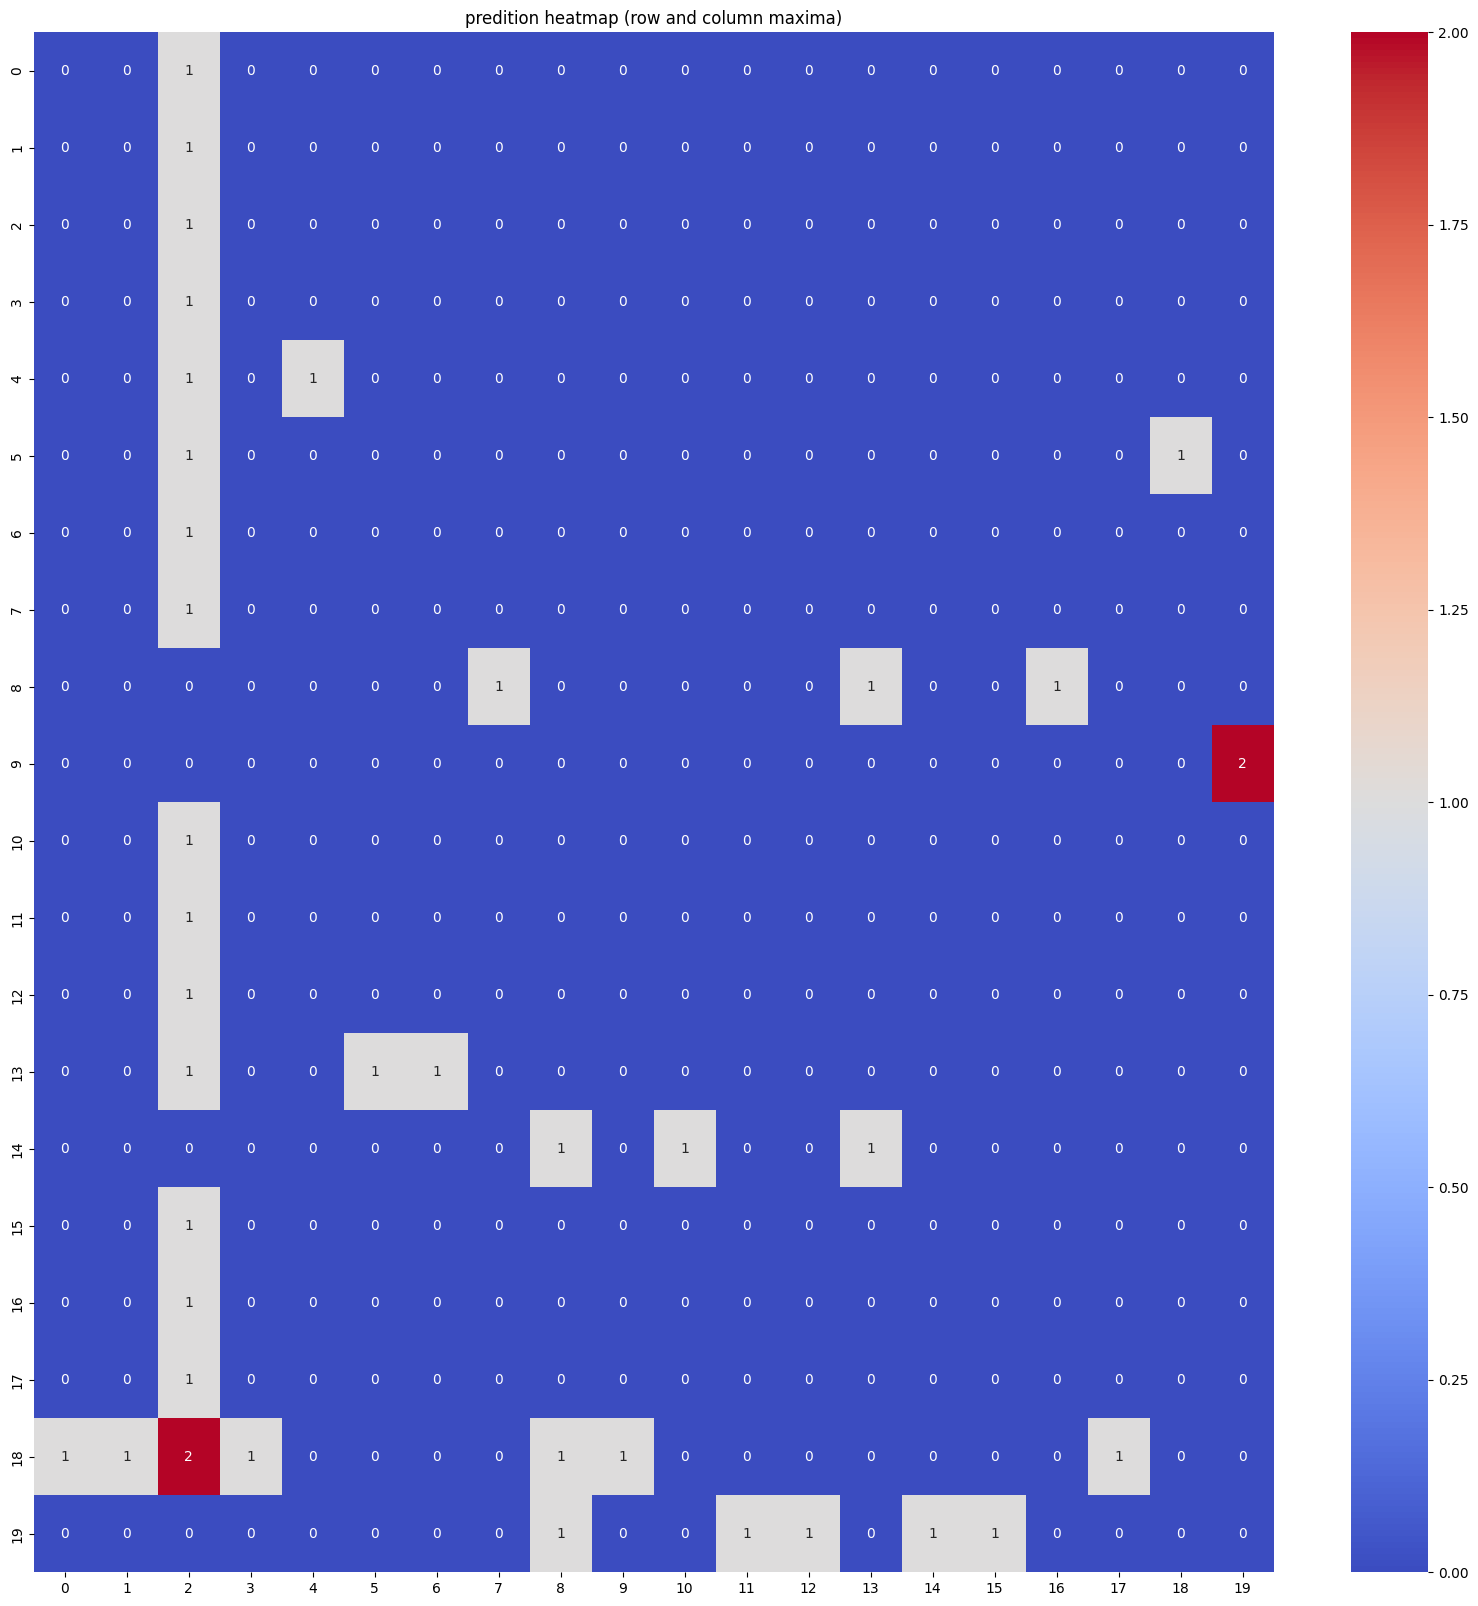

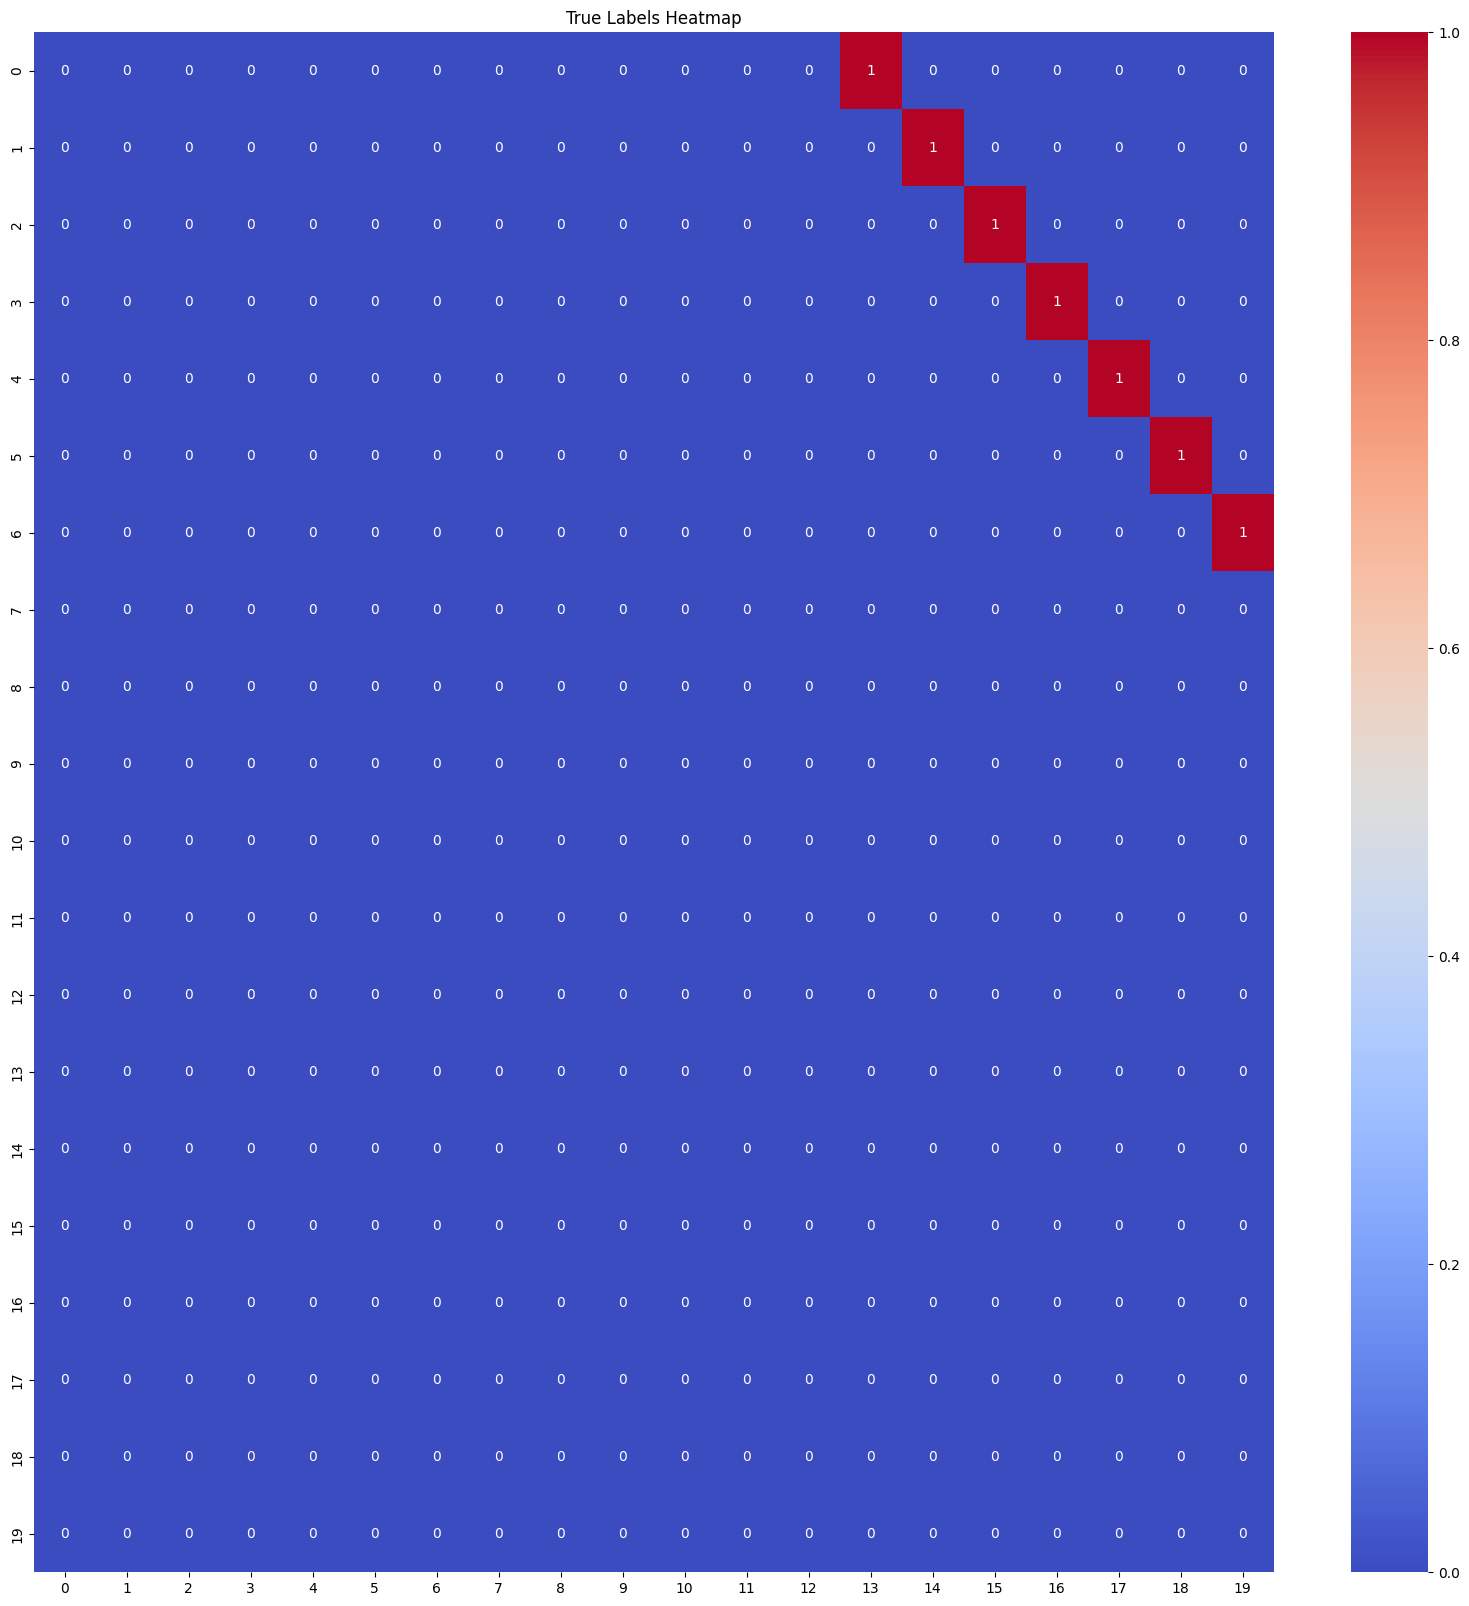

In [16]:
### model training: with loss_3

### problem: the model learned nothing.

# Instantiate the model
mha_model = MultiHeadAttentionModel(num_heads=4, key_dim=48, sequence_length=20)

# Compile the model using the custom loss function
optimizer = Adam(learning_rate=1e-5)
mha_model.compile(optimizer=optimizer, loss=custom_loss)

# Train the model with the specified datasets, number of epochs, and callbacks
mha_model.fit(
    train_dataset,
    epochs=30,
    steps_per_epoch=train_steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=val_steps_per_epoch,
    callbacks=[PredictionCallback(val_dataset)]
)

Epoch 1/100
31/31 [==============================] - 28s 872ms/step - loss: 7634.4771 - val_loss: 942.2518
Epoch 2/100
31/31 [==============================] - 27s 872ms/step - loss: 7629.0244 - val_loss: 938.7697
Epoch 3/100
31/31 [==============================] - 27s 878ms/step - loss: 7639.9976 - val_loss: 942.2441
Epoch 4/100
31/31 [==============================] - 27s 876ms/step - loss: 7631.7285 - val_loss: 942.1458
Epoch 5/100
31/31 [==============================] - 27s 886ms/step - loss: 7644.0474 - val_loss: 940.4537
Epoch 6/100
31/31 [==============================] - 27s 886ms/step - loss: 7636.3608 - val_loss: 941.8504
Epoch 7/100
31/31 [==============================] - 27s 884ms/step - loss: 7634.7354 - val_loss: 939.0972
Epoch 8/100
31/31 [==============================] - 27s 886ms/step - loss: 7633.5625 - val_loss: 936.3928
Epoch 9/100
31/31 [==============================] - 27s 889ms/step - loss: 7631.8691 - val_loss: 941.5532
Epoch 10/100
31/31 [=================

31/31 [==============================] - 12s 395ms/step - loss: 7632.1011 - val_loss: 939.3880
Epoch 69/100
31/31 [==============================] - 12s 395ms/step - loss: 7626.7837 - val_loss: 941.7168
Epoch 70/100
31/31 [==============================] - 12s 396ms/step - loss: 7631.4067 - val_loss: 941.6106
Epoch 71/100
31/31 [==============================] - 12s 394ms/step - loss: 7626.0576 - val_loss: 939.2478
Epoch 72/100
31/31 [==============================] - 12s 398ms/step - loss: 7632.8208 - val_loss: 939.3452
Epoch 73/100
31/31 [==============================] - 12s 384ms/step - loss: 7636.4644 - val_loss: 940.5142
Epoch 74/100
31/31 [==============================] - 12s 401ms/step - loss: 7636.1934 - val_loss: 940.5983
Epoch 75/100
31/31 [==============================] - 12s 395ms/step - loss: 7631.8994 - val_loss: 940.6029
Epoch 76/100
31/31 [==============================] - 12s 400ms/step - loss: 7629.8726 - val_loss: 940.2189
Epoch 77/100
31/31 [=====================

True:
 tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

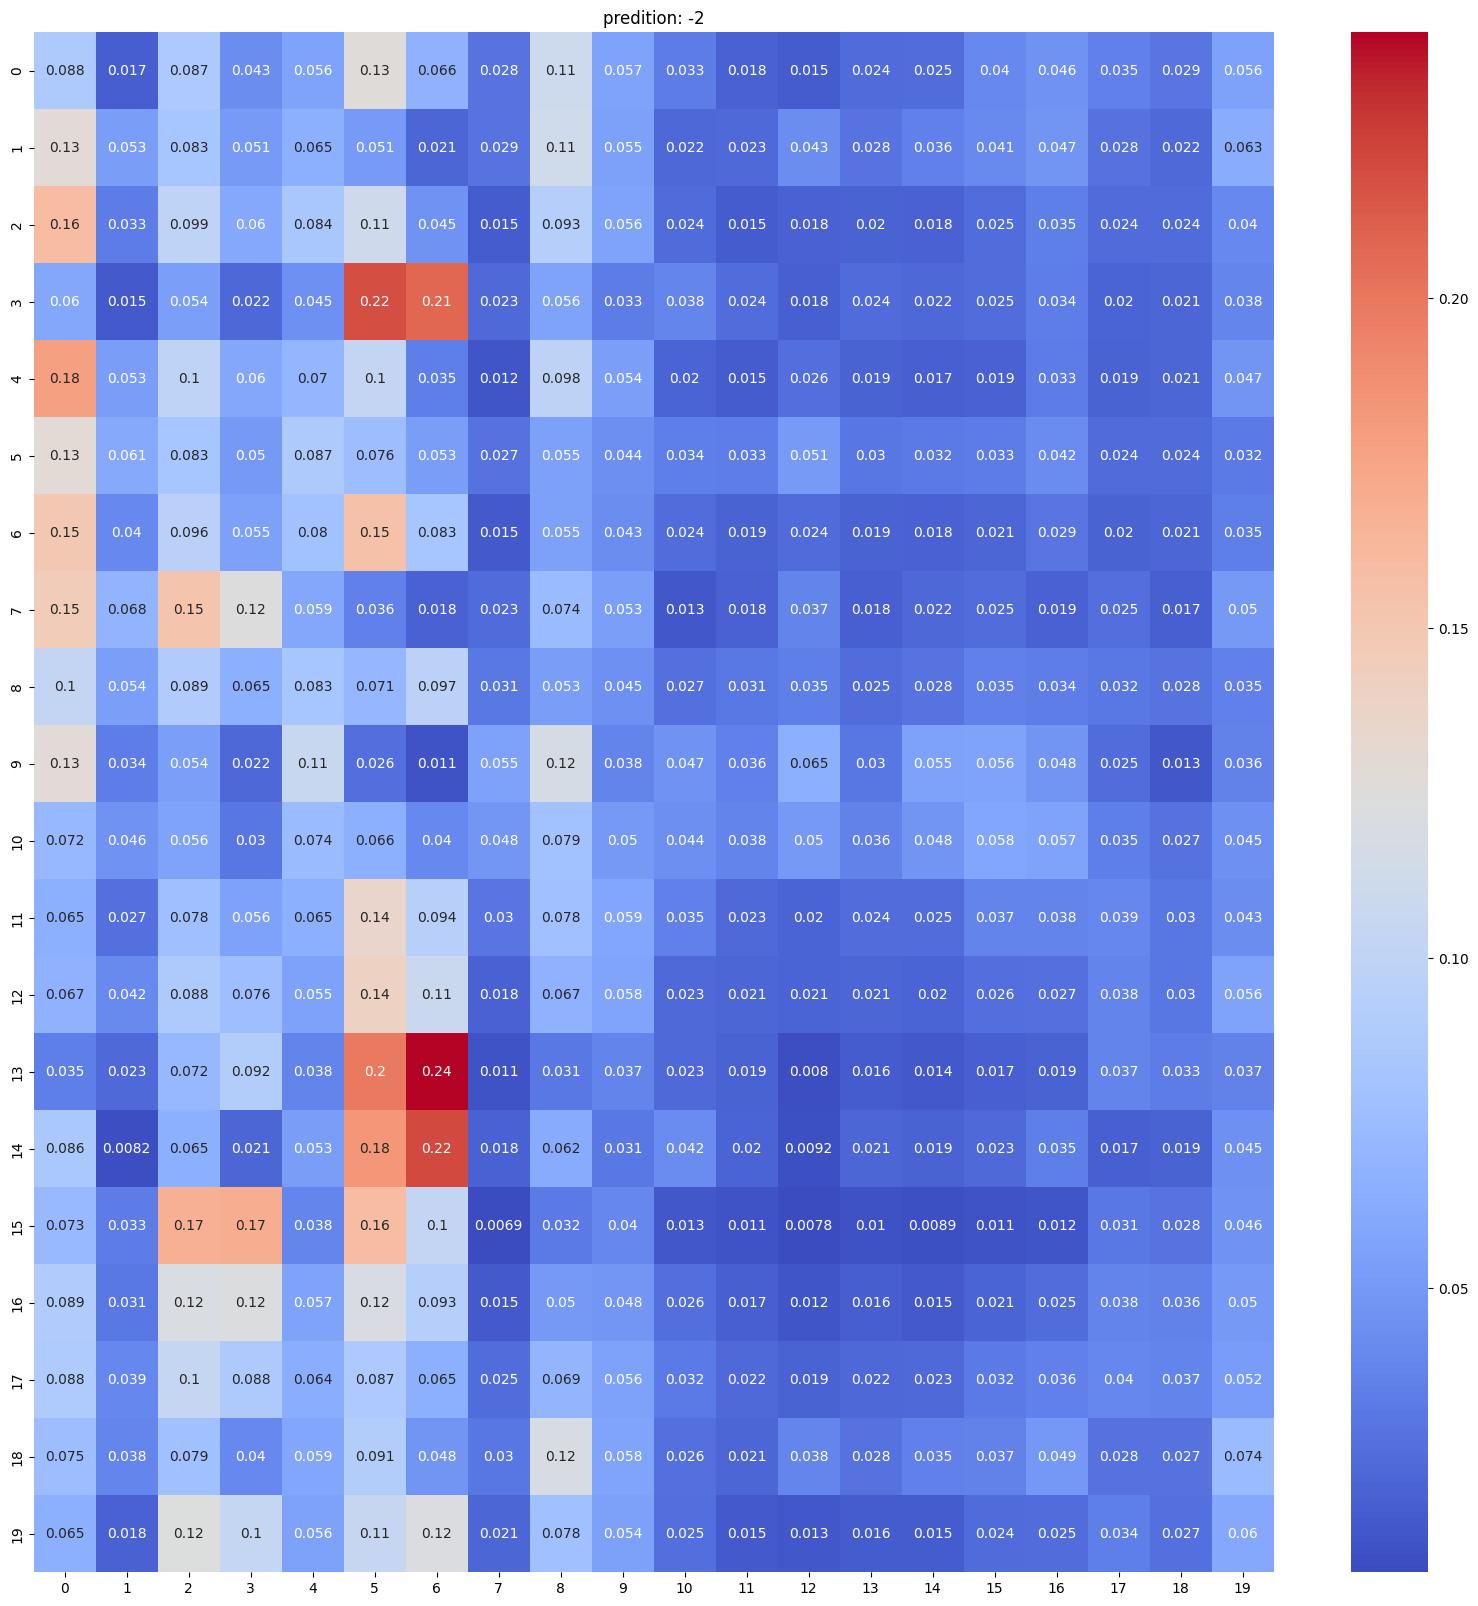

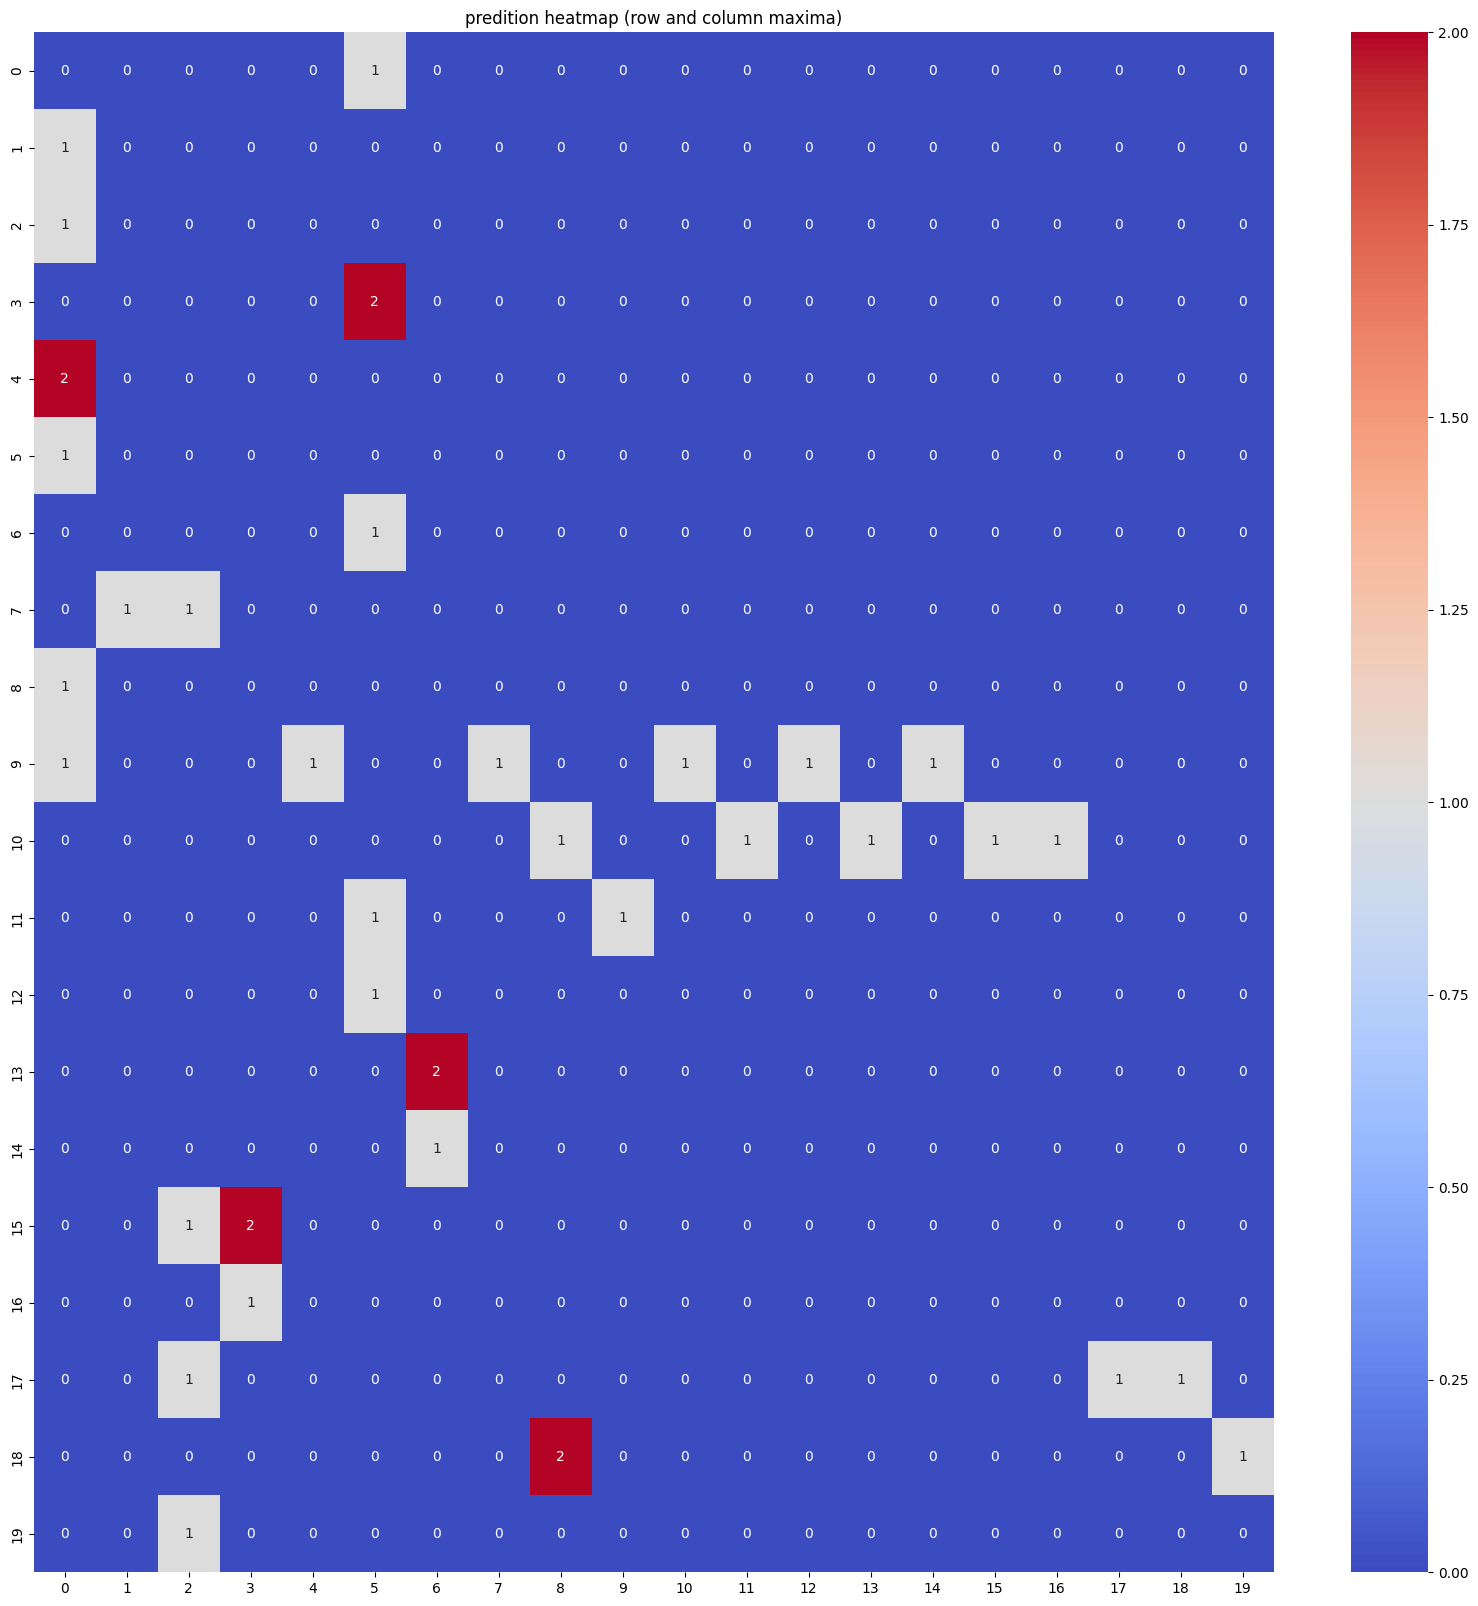

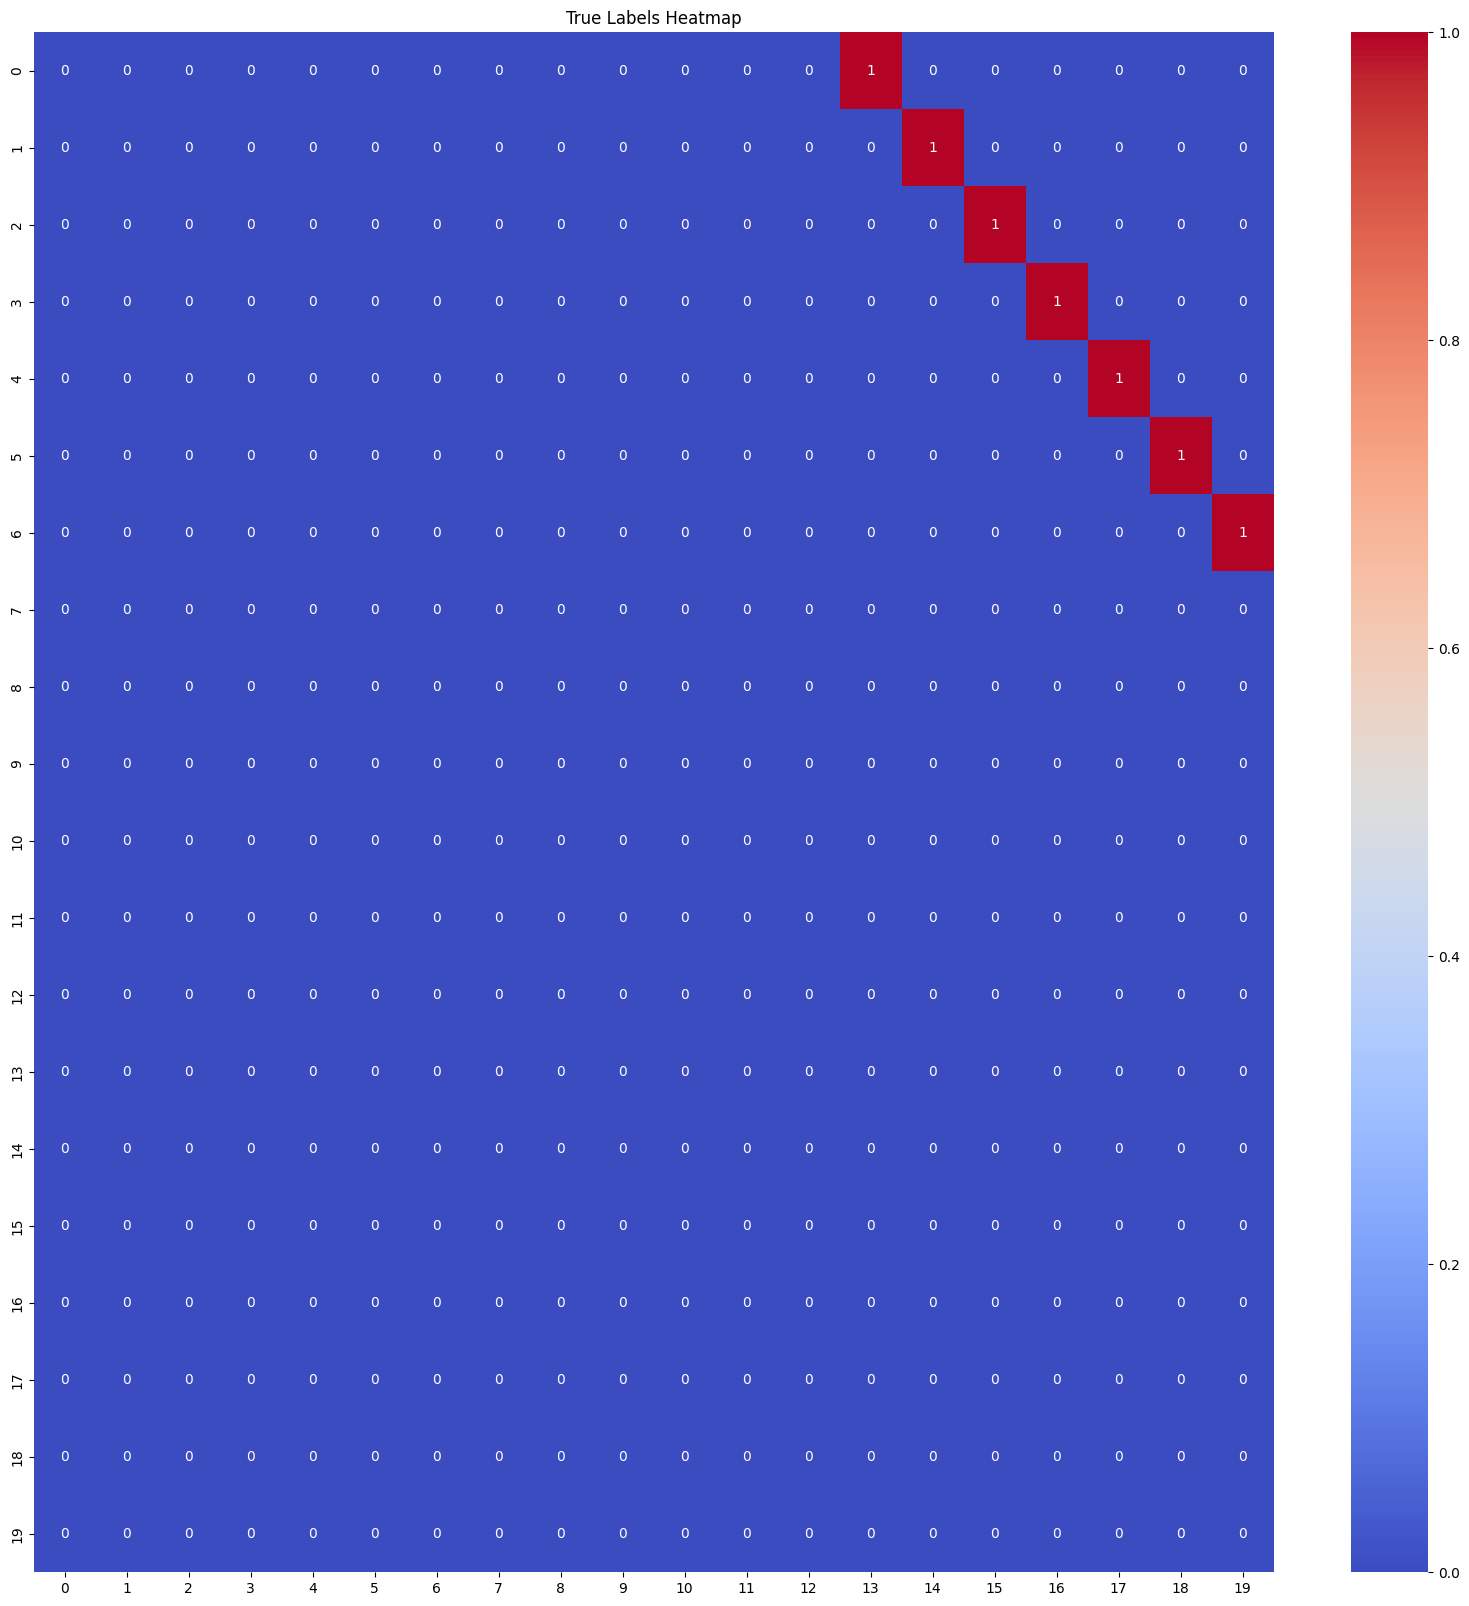

In [8]:
### model training: with loss_4

### problem: the model learned some weird results.

# Instantiate the model
mha_model = MultiHeadAttentionModel(num_heads=4, key_dim=48, sequence_length=20)

# Compile the model using the custom loss function
optimizer = Adam(learning_rate=1e-3)
mha_model.compile(optimizer=optimizer, loss=custom_loss)

# Train the model with the specified datasets, number of epochs, and callbacks
mha_model.fit(
    train_dataset,
    epochs=100,
    steps_per_epoch=train_steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=val_steps_per_epoch,
    callbacks=[PredictionCallback(val_dataset)]
)